In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('..')
from NrnResponse import *
from NSclasses import *
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import seaborn as sns


## nxn Macro grid

In [2]:
def getMacroGrid(nodes):
    #generate a MacroGrid for nxn spatial preferences
    assert(nodes >= 3)
    
    Grid = Mygrid(1, 1, 50, 50)
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    h = Xspace[1] - Xspace[0]
    
    MacroNeurons = [0]*(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            x = Xspace[i]
            y = Yspace[j]
            MacroNeurons[i+j*nodes] = MyNrn(x, y, 
                                             4*np.pi/9, Grid)
            #orientation preference defined based on index (=4) in 3x3 micro grid
    return MacroNeurons, Grid, h

## 3x3 Micro grid

In [3]:
'''Creates 3x3 Micro grid'''
def getMicroGrid(Neuron, h, Grid, micro = 3):
    #for a neuron in the MacroGrid
    #generate 8 surrounding MicroGrid neurons
    #return a 3x3 matrix
    MicroNeurons = [([0]*micro) for i in range(micro)] #fix 3x3
    diff = h/micro
    x, y, the = Neuron.out()
    for i in range(micro):
        for j in range(micro):
            MicroNeurons[j][i] = MyNrn(x+(j-1)*diff, y+(1-i)*diff, 
                                (j+i*micro)*np.pi/(micro**2), Grid)
            
    temp = MicroNeurons[1][1]
    temp_x, temp_y, temp_the = temp.out()
    assert(x == temp_x and y == temp_y and the == temp_the)
    return MicroNeurons


def MicroGridPlot(neurons):
    num = len(neurons)
    X = np.linspace(neurons[0].x -0.5, neurons[-1].x +0.5, 
                         num=50, endpoint=True)
    Y = np.linspace(neurons[0].y +0.5, neurons[-1].y -0.5, 
                         num=50, endpoint=True)
    Z = np.zeros((50, 50))
    
    x = [0]*num
    y = [0]*num
    for i in range(num):
        x[i] = neurons[i].x
        y[i] = neurons[i].y
    
    return x, y

## Neuron Grid

In [204]:
'''Creates the Neuron Grid'''
import pdb

def FindNearest(array, value):
    ind = (np.abs(array - value)).argmin()
    return ind

def getNeuronGrid(nodes, micro = 3, flag=0):
    """
    Nick's version, modified by Ricky
    """
    assert(nodes >= 3)
    assert(micro%2 == 1)
    
    allNeurons = []
    Grid = Mygrid(1, 1, 50, 50)
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    
    #XspaceAll = np.linspace(-1+0.5, 1-0.5, num=nodes*micro, endpoint=True)
    hx = (Xspace[1] - Xspace[0])/micro
    Xglobal = np.arange(-1, 1+hx, hx)
    
    
    #YspaceAll = np.linspace(-1+0.5, 1-0.5, num=nodes*micro, endpoint=True)
    hy = (Yspace[1] - Yspace[0])/micro
    Yglobal = np.arange(-1, 1+hy, hy)
    
    orientations = np.linspace(0, np.pi, micro**2)
    
    allNeurons = []
    for i in range(nodes):
        for micro_i in range(micro):
            for j in range(nodes):
                for micro_j in range(micro):
                    micro_n = micro*(micro_j) + micro_i
                    # i will end up as the row dimension, which is actually y
                    # j will end up as the col dimension, which is actually x
                    x = Xspace[j]
                    y = Yspace[i]
                    
                    Xnode = Xglobal[FindNearest(Xglobal, x - hx*(micro-1)/2)]
                    Xind = int(np.where(Xglobal == Xnode)[0][0]+micro_j)
                    
                    Ynode = Yglobal[FindNearest(Yglobal, y - hy*(micro-1)/2)]
                    Yind = int(np.where(Yglobal == Ynode)[0][0]+micro_i)
                    
                    neuron = MyNrn(x, y, Xind, Yind, orientations[micro_n], Grid)
                    allNeurons.append(neuron)
                    
    Axis = [Xglobal, Yglobal]
    return allNeurons, Axis


# def getNeuronGridBad(nodes, micro = 3, flag = 0):
#     """
#     Deprecated old version
#     """
#     #nodes = number of neurons in the MacroGrid
    
#     MacroNeurons, Grid, h = getMacroGrid(nodes)
#     allNeurons = [0] * (nodes**2 * micro**2)    
    
#     MatrixNeuron = getMicroGrid(MacroNeurons[0], h, Grid, micro = micro)
#     for j in range(1,nodes):
#         temp = getMicroGrid(MacroNeurons[j], h, Grid)
#         MatrixNeuron = np.vstack((temp, MatrixNeuron))
    
#     for i in range(1,nodes):
#         temp_col = getMicroGrid(MacroNeurons[i*nodes], h, Grid)
#         for j in range(1,nodes):
#             temp = getMicroGrid(MacroNeurons[j+i*nodes], h, Grid)
#             temp_col = np.vstack((temp, temp_col))
#         MatrixNeuron = np.hstack((MatrixNeuron, temp_col))
    
#     allNeurons = np.reshape(MatrixNeuron, (1, nodes**2 * micro**2))[0]
    
    
#     if (flag == 100): #plot micro-grid neuron centers
#         allNeurons = np.flip(allNeurons)
#         fig, axes = plt.subplots(nodes,nodes,figsize = [9,8])
        
#         for i in range(nodes):
#             for j in range(nodes):
#                 ax = axes[i,j]
#                 r = i*micro
#                 c = j*nodes*micro**2
#                 temp1 = allNeurons[r+c:r+c+micro]
#                 temp1 = np.transpose(temp1)
#                 temp2 = allNeurons[r+c+nodes*micro:r+c+nodes*micro+micro]
#                 temp2 = np.transpose(temp2)
#                 temp3 = allNeurons[r+c+nodes*micro*2:r+c+nodes*micro*2+micro]
#                 temp3 = np.transpose(temp3)
#                 temp = np.hstack((temp1, temp2, temp3))
#                 x, y = MicroGridPlot(temp)
#                 ax.set_xlim(-1, 1)
#                 ax.set_ylim(-1, 1)
#                 cl = ['b']*micro**2
#                 cl[micro+1] = 'r'
#                 ax.scatter(x, y, color =cl, alpha=0.5)
#         fig.tight_layout()
#         st = fig.suptitle('{2}x{3} MicroGrid in {0}x{1} MacroGrid'.format(nodes,
#                           nodes, micro, micro), 
#               fontsize = 16)
#         st.set_y(0.95)
#         fig.subplots_adjust(top=0.9)
#         allNeurons = np.flip(allNeurons)
        
#     return allNeurons, h/3, MacroNeurons

# doesn't work when micro!=3

# neur_grid, _, _ = getNeuronGridBad(3, micro=3, flag = 100)

In [5]:
Xs = np.linspace(-1+0.5, 1-0.5, num=3, endpoint=True)
h = (Xs[1]-Xs[0])/3
Xglobal = np.arange(-1, 1+h, h)
print(Xs)
#print(Xspace)
print(Xglobal)
print(FindNearest(Xglobal, Xs[0] - h*(3-1)/2))
np.where(Xglobal == -1)[0][0]

[-0.5  0.   0.5]
[-1.00000000e+00 -8.33333333e-01 -6.66666667e-01 -5.00000000e-01
 -3.33333333e-01 -1.66666667e-01 -2.22044605e-16  1.66666667e-01
  3.33333333e-01  5.00000000e-01  6.66666667e-01  8.33333333e-01
  1.00000000e+00  1.16666667e+00]
2


0

In [6]:
# some sanity checks to make sure the full grid looks right
def check(neur_grid, Y, n, micro):
    resps = []
    for ii in range(len(neur_grid)):
        resps.append(neur_grid[ii].x)
        sns.heatmap(np.array(resps).reshape(n*micro,n*micro))
        plt.title('x location')
        plt.show()

    resps = []
    for ii in range(len(neur_grid)):
        resps.append(neur_grid[ii].y)
        sns.heatmap(np.array(resps).reshape(n*micro,n*micro))
        plt.title('y location')
        plt.show()

    resps = []
    for ii in range(len(neur_grid)):
        resps.append(neur_grid[ii].theta)
        sns.heatmap(np.array(resps).reshape(n*micro,n*micro))
        plt.title('theta')
        plt.show()

    resps = Y
    #for ii in range(len(neur_grid)):
        #print(MacroNeurons[ii])
        #resp = NrnResponse(neur_grid[ii],  MyPtStm(0,0, np.pi/2), neur_grid[ii].grid)
    resps.append(Y)
    sns.heatmap(np.array(resps).reshape(n*micro,n*micro))
    plt.title('response to point stimulus')
    plt.show()


## Util functions

In [246]:
def CircularRFwt(target, neurons, radius = 0.5):
    #target: input neuron to generate weights w.r.t others
    #neurons: the list of all other neurons in the same pool as the target
    N = len(neurons)
    r = min(target.grid.xylim)*radius 
    tar_x, tar_y, tar_th = target.out()
    weight = np.zeros(N)
    #neuron i in the list has weight i
    #count = 0
    for i in range(N):
        n_x, n_y, n_th = neurons[i].out()
        
        dist = np.sqrt((tar_x-n_x)**2+(tar_y-n_y)**2+
                        (tar_th-n_th)**2)
        if dist > r:
            weight[i] = 0
        else:
            #count = count + 1
            weight[i] = 1 - dist/r
            
    #if count == 0:
        #count = count + 1
    return weight

def WtResponse(response, weight):
    #returns the sum of weighted responses in the neuron pool
    assert(len(response) == len(weight))
    #response from neuron i is assigned with weight i
    return sum(weight*response)



In [8]:
def GetRes(nodes, neurons, stimu, Grid, micro = 1):
    '''Obtain input response for all neurons'''
    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        res[i] = NrnResponse(neurons[i], stimu, Grid)
    return res

def WeightRes(weights, nodes, neurons, responses, micro = 1):
    '''Obtain weighted-sum response for all neurons
    Extract weights for each neuron: weight
    Compute weighted sum: res'''
    #responses = all responses from input/last step
    
    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        target = neurons[i]
        rest_neurons = np.delete(neurons,i)
        rest_res = np.delete(responses,i)
        #weight = CircularRFwt(target, rest_neurons) 
        #!!! store the weight somewhere else
        res[i] = WtResponse(rest_res, weights[i])
    return res

def NormalizeRes(nodes, neurons, responses, z, micro = 1, **kwargs):
    '''Normalization step1:
    Extract single neuron response: i_tar
    Extract pooled neurons weighted responses: i_pool'''
    #responses = all responses from input/last step
    #z = weighted-sum responses for all neurons

    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        i_pool = z[i]
        i_tar = responses[i]
        res[i] = NormalizedR(i_tar, i_pool, **kwargs)
    return res

def NormalizedR(ini, ini_m, gamma = 1, sigma = 1, exp = 2):
    '''Normalization step2:
    Normalize single neuron's response'''
    #ini = target neuron's response
    #ini_m = other neurons' responses (weighted sum)
    nom = ini**exp
    denom = sigma**exp + ini_m**exp + nom
    return gamma* (nom/denom)

def ToMatrix(nodes, arr, micro = 1):
    '''Reshape an array of responses into matrix'''
    res = np.reshape(arr, (nodes*micro, nodes*micro))

    return res

# def getGlobalAxis(Xspace, Yspace):
#     '''Reconstruct the [-1,1]x[-1,1] global grid'''
#     hx = Xspace[1]-Xspace[0]
#     Xleft = np.arange(-1, Xspace[0], hx)
#     Xright = np.arange(Xspace[-1], 1, hx)
#     #global X axis
#     GX = np.hstack([Xleft[:-1], Xspace, Xright[1:]])
    
#     Xleft_ind = len(Xleft)-1
#     Xright_ind = len(Xleft)+len(Xspace)-1-1
    
#     hy = Yspace[1]-Yspace[0]
#     Yleft = np.arange(-1, Yspace[0], hy)
#     Yright = np.arange(Yspace[-1], 1, hy)
#     #global Y axis
#     GY = np.hstack([Yleft[:-1], Yspace, Yright[1:]])
    
#     Yleft_ind = len(Yleft)-1
#     Yright_ind = len(Yleft)+len(Yspace)-1-1
    
#     return [Xleft_ind, Xright_ind], [Yleft_ind, Yright_ind], GX, GY

## Visualization

In [70]:
def visualizeGridRF9x9(neurgrid):
    'Nick\'s version, modified by Ricky'
    neur_grid_curves = [neurgrid[ii].PosCurve() for ii in range(81)]

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(9, 9),  # creates 2x2 grid of axes
                     axes_pad=0.2,  # pad between axes in inch.
                     share_all=True)

    for ax, im in zip(grid, neur_grid_curves):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, extent = [-1, 1, -1, 1], aspect='auto')

    plt.show()

def visualizeGridWt9x9(neurgrid):
    'Nick\'s version, modified by Ricky'
    neur_grid_curves = [CircularRFwt(neuron, neurgrid, radius=1).reshape(9,9) 
                        for neuron in neurgrid]
    # counts = [CircularRFwt(neuron, neur_grid, radius=1)[1] 
    #           for neuron in neur_grid]
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(9, 9),  # creates nxn grid of axes
                     axes_pad=0.2,  # pad between axes in inch.
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="edge",
                     cbar_size="5%",
                     cbar_pad=0.3)

    for ax, data in zip(grid, neur_grid_curves):
        # Iterating over the grid returns the Axes.
        im = ax.imshow(data)

        ax.cax.colorbar(im)
    plt.show()

def visualizeSingleWt9x9(neurgrid):
    'Nick\'s version, modified by Ricky'
    r = 4
    neur_grid_curves = [CircularRFwt(neuron, neurgrid, radius=r).reshape(9,9) 
                        for neuron in neurgrid]
    # counts = [CircularRFwt(neuron, neur_grid, radius=1)[1] 
    #           for neuron in neur_grid]
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 1),  # creates nxn grid of axes
                     axes_pad=0.2,  # pad between axes in inch.
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="edge",
                     cbar_size="5%",
                     cbar_pad=0.3)
    #print(neur_grid_curves[0])
    for ax, data in zip(grid, [neur_grid_curves[0]]):
        # Iterating over the grid returns the Axes.
        im = ax.imshow(data)

        ax.cax.colorbar(im)
    ax.set_title('Single neuron circular weights, r = {}'.format(r))
    plt.show()

<IPython.core.display.Javascript object>


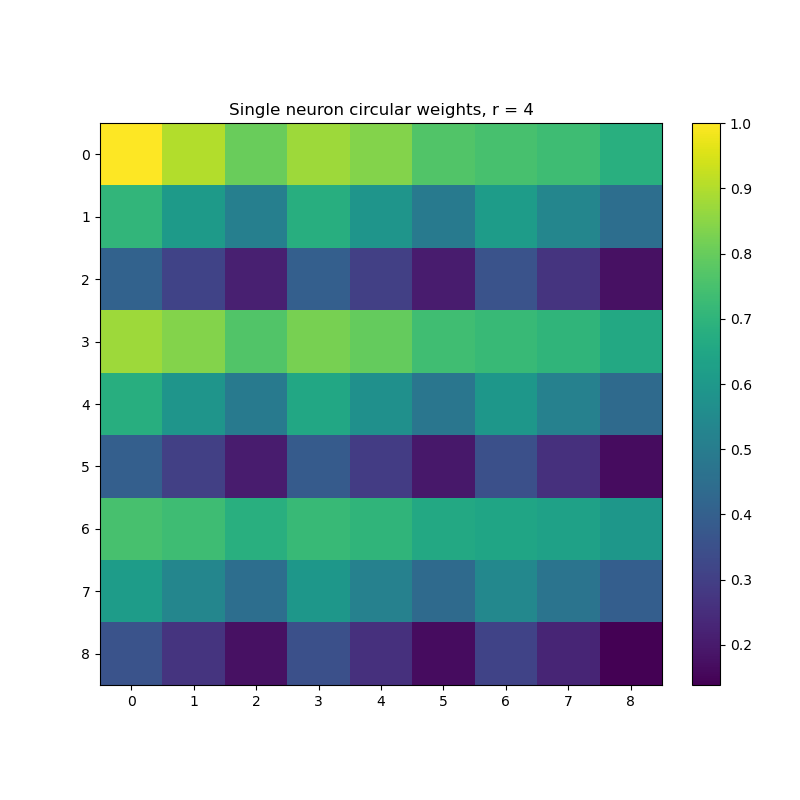

In [71]:
neur_grid, _, = getNeuronGrid(3, micro=3)
#visualizeGridRF9x9(neur_grid)
#visualizeGridWt9x9(neur_grid)
visualizeSingleWt9x9(neur_grid)

## Initialization for Time Model

In [11]:
def MicroInitialization(nodes, micro = 1):
    '''Initializes Neuron grid'''
    assert(nodes >= 3)
    
    Grid = Mygrid(1, 1, 50, 50)

    neurons, Axis = getNeuronGrid(nodes, micro = 3, flag = 0)
    
    return neurons, Axis, Grid

In [12]:
### Iteration in time model ver.1.2.3 ###

def TimeModelwithMicro(number, total, time_off, 
                       micro = 3, radius= 1, 
                       stim_x= 0, stim_y= 0, stim_theta= np.pi/2,
                       gamma = 1, sigma = 1, exp = 2,
                      ):
    T = total 
    nodes = number
    
    S_ti = []
    #for i in range(time_off):
    #    S_ti.append(MyPtStm(-0.5+i/time_off, -0.5-i/time_off, np.pi/4))
        
        
    Sti = MyPtStm(stim_x, stim_y, stim_theta) #initial point stimulus
    
    S_t = []
    T_on = 0; T_off = time_off
    for i in range(T):
        if (i < T_off):
            #S_t.append(S_ti[i])
            S_t.append(Sti)
        else:
            S_t.append(0)
    #initialization here
    neurons, Axis, Grid = MicroInitialization(nodes, micro)
    X = []
    Y = []

    weights = []
    #calculate the weights for each neuron
    for i in range(len(neurons)):
        target = neurons[i]
        rest_neurons = np.delete(neurons,i)
        weight = CircularRFwt(target, rest_neurons, radius)
        weights.append(weight)
    
    if S_t[0] != 0:
        X.append(GetRes(nodes, neurons, S_t[0], Grid, micro))
        #print('len:X[0],',len(X[0]))
        z = WeightRes(weights, nodes, neurons, X[0], micro)
        #print('len:z,',len(z))
    else:
        X.append(np.zeros(nodes**2*(micro**2))) #new
        z = 0
    Y.append(NormalizeRes(nodes, neurons, X[0], z, micro, 
                          gamma=gamma, sigma=sigma, exp=exp))
    #print('len:Y[0],',len(Y[0]))
    #check(neurons, Y[0], number, micro)
    
    
    
    for i in range(1,T):
        if S_t[i] != 0:
            X.append(GetRes(nodes, neurons, S_t[i], Grid, micro))
            z =  WeightRes(weights, nodes, neurons, X[i]+Y[i-1], micro) #update
        else:
            X.append(np.zeros(nodes**2*(micro**2))) #new
            z = WeightRes(weights, nodes, neurons, Y[i-1], micro)
        Y.append(NormalizeRes(nodes, neurons, Y[i-1]+X[i], z, micro,
                              gamma=gamma, sigma=sigma, exp=exp)) #update
        
    
    return neurons, Axis, Y, X

In [181]:
def run(n, t_total, t_off, micro, **kwargs):
    neurons, Axis, Y, X = TimeModelwithMicro(n, t_total, t_off, **kwargs)
    #Xind, Yind, GbX, GbY = getGlobalAxis(Xspace, Yspace)
    #Xleft = Xind[0]; Xright = Xind[1];
    #Yleft = Yind[0]; Yright = Yind[1];
    Xglobal, Yglobal = Axis[0], Axis[1]
    
    N = len(Y)
    MatrixY = []
    #first frame is the un-normalized response
    Xtmp = ToMatrix(n,X[0],micro)
    Ntmp = ToMatrix(n,neurons,micro)
    container = np.zeros((len(Xglobal),len(Yglobal)))
        
    for j in range(n*micro):
        for k in range(n*micro):
            container[Ntmp[j,k].Xind,Ntmp[j,k].Yind] = Xtmp[j,k]
    MatrixY.append(container)
    
    for i in range(N):
        container = np.zeros((len(Xglobal),len(Yglobal)))
        Ytmp = ToMatrix(n,Y[i],micro)
        assert(Ntmp.shape == Ytmp.shape)
        
        for j in range(n*micro):
            for k in range(n*micro):
                container[Ntmp[j,k].Xind,Ntmp[j,k].Yind] = Ytmp[j,k]
                
        #container[Xleft:Xright+1, Yleft:Yright+1] = ToMatrix(n,Y[i], micro = micro)

        MatrixY.append(container) 
    return Xglobal, Yglobal, MatrixY, Y, X[0]




In [72]:
x = np.random.rand()-0.5 #random from [-0.5, 0.5)
y = np.random.rand()-0.5 #random from [-0.5, 0.5)
theta = np.random.rand()*np.pi #random from [0, pi)

Xaxis, Yaxis, MatrixY, Y, Xinit = run(10, 30, 10, 
                           micro = 3, radius=4, 
                           stim_x=x, stim_y=y, stim_theta=theta,
                           gamma = 1, sigma = 1, exp = 2,)
print(len(Y[0]))
print(len(Xinit))
print(np.where(Xinit == max(Xinit)))
print(np.where(Y[0] == max(Y[0])))
print(max(Xinit))
print(max(Y[0]))

900
900
(array([725]),)
(array([812]),)
0.5919831008802336
9.107622412573188e-05


In [97]:
def testRadius(n, flag = 0, k = 0):
    
    if (flag == 1): 
        r = np.linspace(1.+k,0.05,num=20+int(-1*k/0.05), endpoint=True)
    else:
        r = np.linspace(1.,0.05,num=20, endpoint=True)
    Yarray = []
    Xarray = []
    x = np.random.rand()-0.5 #random from [-0.5, 0.5)
    y = np.random.rand()-0.5 #random from [-0.5, 0.5)
    theta = np.random.rand()*np.pi #random from [0, pi)
    for i in range(len(r)):
        
        Xaxis, Yaxis, MatrixY, Y, Xinit = run(n, 20, 10, 
                           micro = 3, radius=r[i], 
                           stim_x=x, stim_y=y, stim_theta=theta,
                           gamma = 1, sigma = 1, exp = 2,)
        assert(len(Y[0])==len(Xinit))
        Xarray.append(np.where(Xinit == max(Xinit))[0][0])
        Yarray.append(np.where(Y[0] == max(Y[0]))[0][0])
        if(Xarray[i]==Yarray[i]):
            #print('best r: ',r[i])
            #print('max ind: ',Xarray[i])
            return r[i]
        
    #print('no suitable radius')
    return 0
 
def histRadius(n, m = 3):
    radii = []
    flag = 0; k = 0
    for i in range(30):
        radii.append(testRadius(n, flag, k))
        if (radii[-1] < 0.5):
            flag = 1
            if (k > 0.2): k -= 0.1
        else:
            flag = 0;
            
    print('mean for n = {0}: {1}'.format(n,np.mean(radii)))
    return radii, np.mean(radii), np.std(radii), n*n*m*m

def getRadiusData(start,end,m = 3):
    N = end-start+1
    radiiData = [0]*N
    meanData = [0]*N
    stdData = [0]*N
    size = [0]*N
    for i in range(N):
        radiiData[i], meanData[i], stdData[i], size[i] = histRadius(i+start)
        assert(i+start <= end)
    return radiiData, meanData, stdData, size

In [99]:
radiiData, meanData, stdData, size = getRadiusData(3,8,m = 3)

# plt.hist(radii)
# text = 'Viable radii for {}-neuron Neuron grid'.format()
# plt.title(text)



mean for n = 3: 0.7533333333333334
mean for n = 4: 0.7216666666666666
mean for n = 5: 0.6500000000000001
mean for n = 6: 0.3833333333333334
mean for n = 7: 0.3066666666666667
mean for n = 8: 0.25666666666666677


'''

what to do now: 
    for each simulation: steady state when the stimulus is on, 
    some intermediate point 
    
    check that the last unit maintain activity is the most sensitive to the stimulus
    
    change the stimulus position/orientation
    
    change the parameters of the normalization function



'''
r = 3, bestR mean = 0.895 0.753
r = 4, bestR mean = 0.618 0.722
r = 5, bestR mean = 0.533 0.65
r = 6, bestR mean = 0.401 0.383
r = 7, bestR mean = 0.293 0.307
r = 8, bestR mean = 0.257


<IPython.core.display.Javascript object>


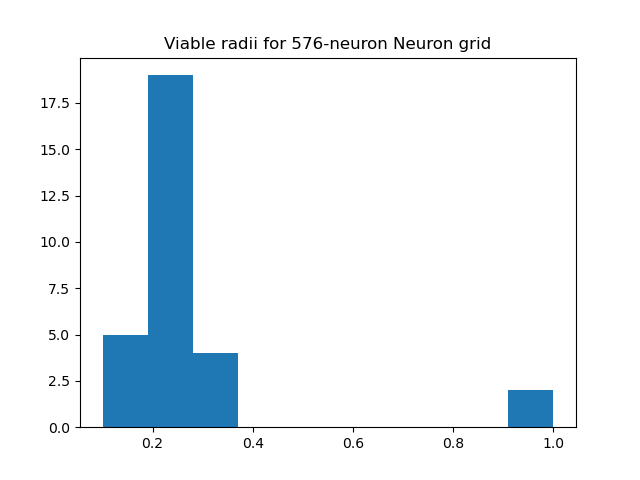

Text(0.5, 1.0, 'Viable radii for 576-neuron Neuron grid')

In [106]:
plt.hist(radiiData[5])
text = 'Viable radii for {}-neuron Neuron grid'.format(size[5])
plt.title(text)

<IPython.core.display.Javascript object>


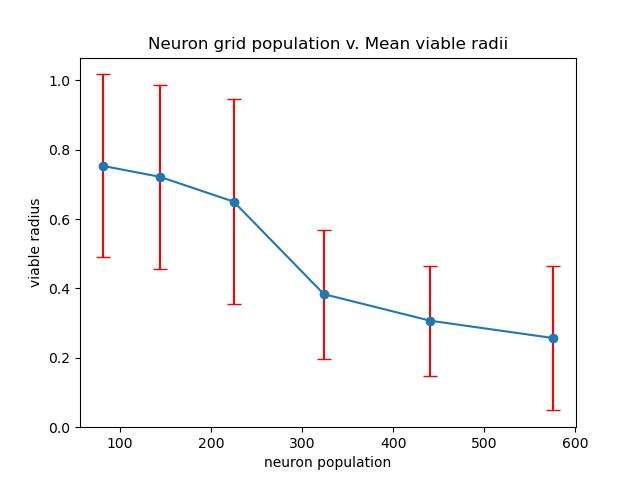

Text(0.5, 1.0, 'Neuron grid population v. Mean viable radii')

In [116]:
plt.errorbar(size, meanData, stdData, marker = 'o',ecolor='r',capsize = 5)
plt.xlabel('neuron population')
plt.ylabel('viable radius')
plt.title('Neuron grid population v. Mean viable radii')

In [294]:


%matplotlib notebook
def getAnimation(Xaxis, Yaxis, MatrixY, size, flag):


    fr = len(MatrixY)
    fig,ax = plt.subplots(figsize = (6,6))
    def animate(i):
        ax.clear()
        ax.axis('off')
#         p?db.set_trace()
        if flag == 1: #contour plot
            ax.contourf(Xspace, Yspace, MatrixY[i], cmap='hot')
        if flag == 2: #seaborn heatmap
            sns.heatmap(MatrixY[i], cmap='hot', ax=ax, cbar=False)
        ax.set_title('T = %03d'%(i)) 

        
    ani =  matplotlib.animation.FuncAnimation(fig,animate,frames=fr,
                                              interval=300,blit=False)

    ani.save('(3x3).gif',  writer='pillow', fps=10)
    ani.show()

def MatrixPlot(Xaxis, Yaxis, MatrixY, size, flag):
    N = len(MatrixY)

    fig, axes = plt.subplots(int(N/5), 5, figsize = [15,15])
    if flag == 1 :#contour plot
        for i in range(N):
            ax = axes[int(i/5),(i%5)]
            ax.axis('off')
            if (i > 0):
                ax.title.set_text('T = {}'.format(i-1))
            else:
                ax.title.set_text('Pre-normalized')
            #add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)

            im = ax.contourf(Xspace, Yspace, MatrixY[i],  cmap='hot')
            fig.colorbar(im, cax=cax, orientation='vertical')
            
    if flag == 2 :#seaborn heatmap plot
        i = 0
        for ax in axes.flat:
            ax.axis('off')
            if (i > 0):
                ax.title.set_text('T = {}'.format(i-1))
            else:
                ax.title.set_text('Pre-normalized')
            sns.heatmap(MatrixY[i],ax=ax, cmap='hot', 
                        cbar = True)
            i += 1
    title = "{0}-neuron Neuron grid\n S(0, 0, $pi/2$), $t\_off$ = 10\n r = 1, Z(1,1,2)".format(size)
    plt.suptitle(title, fontsize=20)



441
441
(array([220]),)
(array([286]),)
0.6218676385930111
0.0007082920364520786


<IPython.core.display.Javascript object>


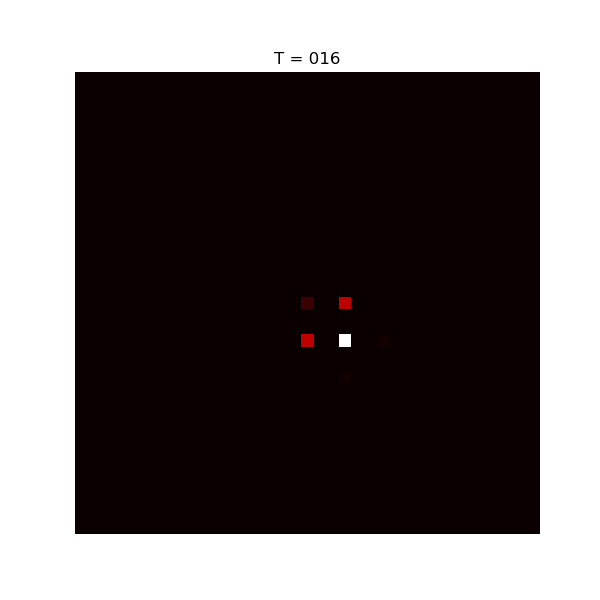

AttributeError: 'FuncAnimation' object has no attribute 'show'

In [298]:
x = np.random.rand()-0.5 #random from [-0.5, 0.5)
y = np.random.rand()-0.5 #random from [-0.5, 0.5)
theta = np.random.rand()*np.pi #random from [0, pi)

Xaxis, Yaxis, MatrixY, Y, Xinit = run(7, 30, 10, 
                           micro = 3, radius=1., 
                           stim_x=0, stim_y=0, stim_theta=np.pi/2,
                           gamma = 1, sigma = 1, exp = 2,)
print(len(Y[0]))
print(len(Xinit))
print(np.where(Xinit == max(Xinit)))
print(np.where(Y[0] == max(Y[0])))
print(max(Xinit))
print(max(Y[0]))
#print(x, y, theta)
getAnimation(Xaxis, Yaxis, MatrixY, len(Y[0]), 2)


<IPython.core.display.Javascript object>


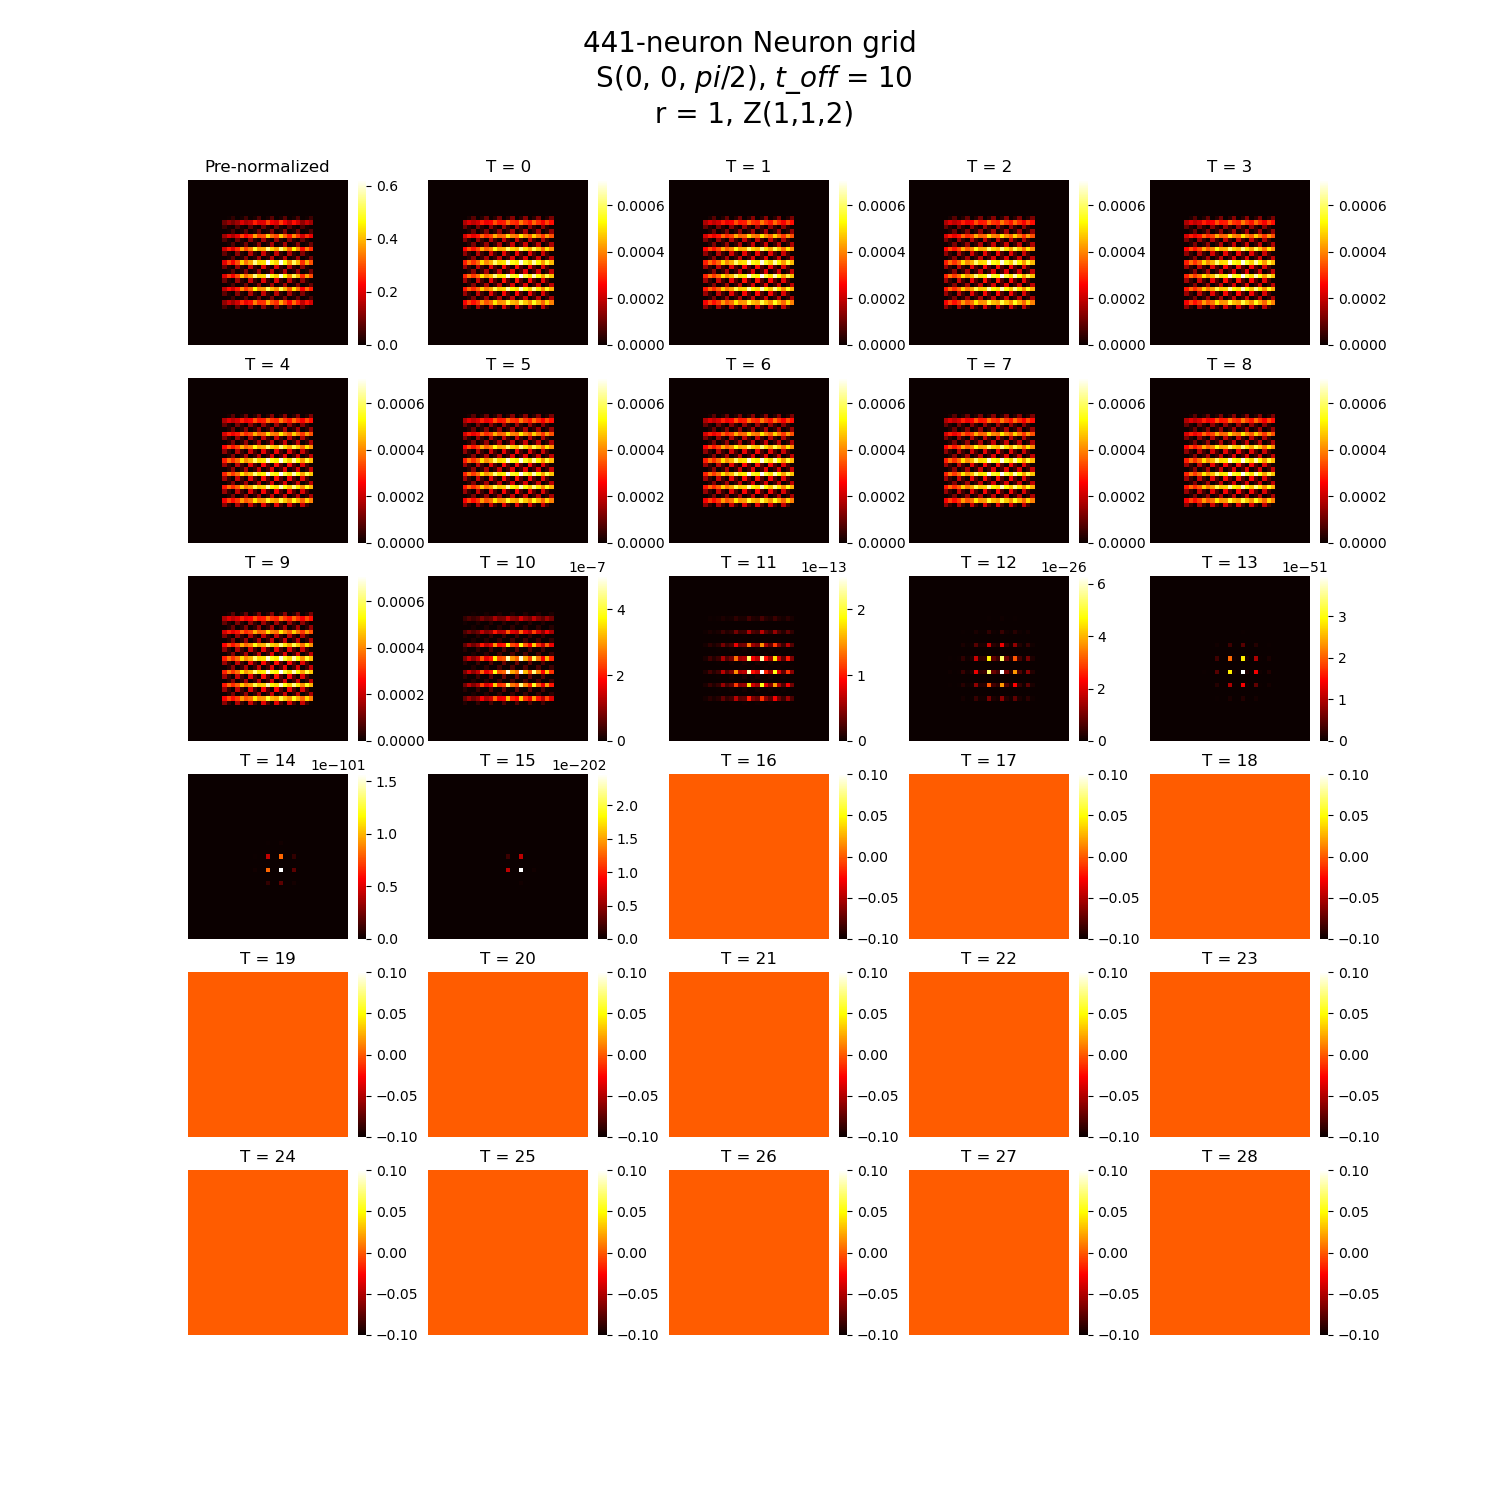

In [299]:
MatrixPlot(Xaxis, Yaxis, MatrixY, len(Y[0]), 2)